# Predicting NBA Draft Picks
Fall 2020 Data 144 Final Project

Team Koolgle: Sid Karia, Kevin Moy, Joyce Li, John Um, and Jessica Wu

## Import

In [1]:
import pandas as pd
!pip install xlrd
!pip install seaborn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_excel('ballas.xlsx')
data.head()

,Name,Pick,Draft Year,Position,Draft Height,Draft Weight,Draft Age,College,Useless1,Useless2,...,FT%,OFF,DEF,TRB,AST,STL,BLK,PF,TOV,PTS
0,John Wall,1,2010,PG,193,95,19,Kentucky,CAREER,NCAA DI,...,0.754,0.81,3.49,4.30,6.43,1.78,0.51,1.95,4.00,16.65
1,Evan Turner,2,2010,GF,201,100,21,Ohio State,CAREER,NCAA DI,...,0.758,1.50,5.26,6.75,4.10,1.58,0.73,2.70,3.49,15.02
2,Derrick Favors,3,2010,FC,185,120,18,Georgia Tech,CAREER,NCAA DI,...,0.629,3.00,5.42,8.42,1.03,0.89,2.06,2.61,2.50,12.44
3,Wesley Johnson,4,2010,GF,201,98,22,Syracuse,CAREER,NCAA DI,...,0.768,2.25,4.74,6.99,1.61,1.14,1.16,2.27,2.15,13.90
4,DeMarcus Cousins,5,2010,C,185,122,19,Kentucky,CAREER,NCAA DI,...,0.607,4.08,5.79,9.87,1.00,0.97,1.76,3.21,2.08,15.13


## Initial Data Exploration & Visualization — John, Joyce

In [3]:
data = data.rename(columns={"3PMS": "3PM"})
data.columns

Index(['Name', 'Pick', 'Draft Year', 'Position', 'Draft Height',
       'Draft Weight', 'Draft Age', 'College', 'Useless1', 'Useless2',
       'useless3', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OFF', 'DEF', 'TRB', 'AST', 'STL', 'BLK', 'PF',
       'TOV', 'PTS'],
      dtype='object')

### Explore Initial Simple Features To Check Data Feasibility

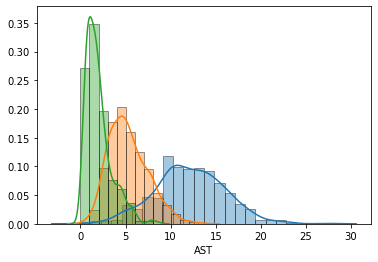

In [4]:
#Points Per Game = Blue
display(sns.distplot(data['PTS'], hist=True, kde = True, hist_kws={'edgecolor': 'black'}))
#data[['PTS']].describe()

#Rebounds = Orange
bins1 = np.arange(0, max(data['TRB']))
display(sns.distplot(data['TRB'], hist=True, kde = True, bins = bins1, hist_kws={'edgecolor': 'black'}))

#Assists = Green
bins2 = np.arange(0, max(data['AST']))
display(sns.distplot(data['AST'], hist=True, kde = True, bins = bins2, hist_kws={'edgecolor': 'black'}))

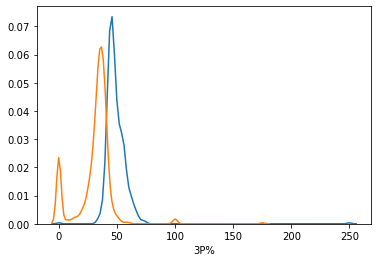

In [5]:
#FG% = Blue
bins3 = np.arange(0, max(data['FG%']), 5)
display(sns.distplot(data['FG%']*100, bins=bins3, hist=True, kde = True, hist_kws={'edgecolor': 'black'}))

#3P% = Orange
display(sns.distplot(data['3P%']*100, bins = bins3,hist=True, kde = True, hist_kws={'edgecolor': 'black'}))

**TLDR; data points seem reasonable**

- PPG: most players have PPG around 8-16 (1 sd around mean) — not super useful info, but makes sense
- RPG: rebounds per game is around 3-7 — also not very useful but reasonable values
- APG: assists per game around 1-3, pretty low averages but makes sense given college player levels + scoring is better for players in college
- FG%: there is an outlier at 0%, need to look into why. An avg FG% is around 48%.
- 3P%: there are multiple outliers to look into (for example the one near 0 and 100%), need to look into them. There are also less data values (258 vs 277), look into why, and avg 3P% is 34%

### Adding Pick Group as our Target Feature
We decided to predict the general group that each player would be a part of rather than their exact pick number to simplify the question, since predicting Pick number accurately is difficult given that there are immeasurable variables such as leadership, work ethic, etc.

In [6]:
#Group by pick and average stats
pick_grp = data.groupby('Pick').mean()
pick_grp

#Separate into lottery (1-14), late first round picks (15-30), and 2nd rounders (31-60)

lottery = pick_grp.loc[1:14]

late_first = pick_grp.loc[15:30]

scnd_round = pick_grp.loc[31:60]

In [7]:
group_lst = []

for i in range(len(data['Name'])):
    if data.iloc[i]['Pick'] <= 14:
        group_lst.append(0)
    if data.iloc[i]['Pick'] > 14 and data.iloc[i]['Pick'] <= 30:
        group_lst.append(1)
    if data.iloc[i]['Pick'] > 30 and data.iloc[i]['Pick'] <= 60:
        group_lst.append(2) 

data['Pick Group'] = group_lst
data

,Name,Pick,Draft Year,Position,Draft Height,Draft Weight,Draft Age,College,Useless1,Useless2,...,OFF,DEF,TRB,AST,STL,BLK,PF,TOV,PTS,Pick Group
0,John Wall,1,2010,PG,193,95,19,Kentucky,CAREER,NCAA DI,...,0.81,3.49,4.30,6.43,1.78,0.51,1.95,4.00,16.65,0
1,Evan Turner,2,2010,GF,201,100,21,Ohio State,CAREER,NCAA DI,...,1.50,5.26,6.75,4.10,1.58,0.73,2.70,3.49,15.02,0
2,Derrick Favors,3,2010,FC,185,120,18,Georgia Tech,CAREER,NCAA DI,...,3.00,5.42,8.42,1.03,0.89,2.06,2.61,2.50,12.44,0
3,Wesley Johnson,4,2010,GF,201,98,22,Syracuse,CAREER,NCAA DI,...,2.25,4.74,6.99,1.61,1.14,1.16,2.27,2.15,13.90,0
4,DeMarcus Cousins,5,2010,C,185,122,19,Kentucky,CAREER,NCAA DI,...,4.08,5.79,9.87,1.00,0.97,1.76,3.21,2.08,15.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Jaylen Hands,56,2019,G,190,86,20,UCLA,CAREER,NCAA DI,...,0.47,3.34,3.81,4.41,1.16,0.16,1.39,2.53,12.08,2
596,Jordan Bone,57,2019,SG,190,84,21,Tennessee,CAREER,NCAA DI,...,0.35,2.06,2.41,4.26,0.67,0.06,1.24,1.58,9.69,2
597,Miye Oni,58,2019,SF,196,93,22,Yale,CAREER,NCAA DI,...,0.82,5.38,6.20,3.30,0.85,1.02,2.82,2.55,15.03,2
598,Dewan Hernandez,59,2019,FC,185,107,22,Miami (FL),CAREER,NCAA DI,...,1.72,3.16,4.88,0.31,0.45,0.88,1.89,1.16,8.62,2


### Visualizing Pick #'s Per Position
We hypothesize that Position will have visible effect on Draft Position

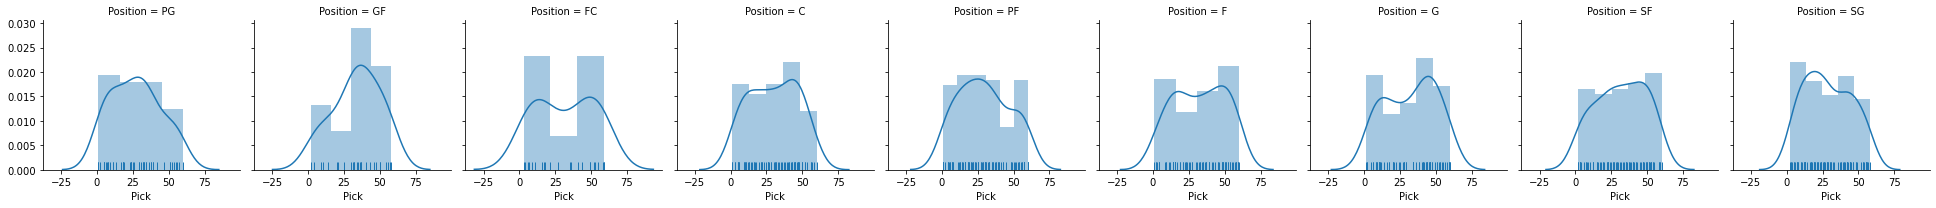

In [8]:
#use FacetGrid to visualize player positions vs picks
picks = sns.FacetGrid(data,col = 'Position', palette="Set1")
picks.map(sns.distplot, 'Pick', hist=True, rug=True)

### Adding Height Differential Features to dataset
We also hypothesize that height will have a visible effect on pick, so we added a height differential feature that compared the height of each player compared to the avg height of those in their pick group.

In [9]:
#COMPARING HEIGHTS TO AVG PICK GROUP HEIGHTS
pos_grp = data.groupby('Pick Group').mean()['Draft Height']
dic = pos_grp.to_dict()

#Creating a list of all heights to make it easier to create df column
heights = []
for i in data['Pick Group']:
    heights.append(dic[i])

#Creating the column of height diff by subtracting average height from players height
data['Height Diff Pick Group'] = data['Draft Height'] - heights
data

,Name,Pick,Draft Year,Position,Draft Height,Draft Weight,Draft Age,College,Useless1,Useless2,...,DEF,TRB,AST,STL,BLK,PF,TOV,PTS,Pick Group,Height Diff Pick Group
0,John Wall,1,2010,PG,193,95,19,Kentucky,CAREER,NCAA DI,...,3.49,4.30,6.43,1.78,0.51,1.95,4.00,16.65,0,-4.257143
1,Evan Turner,2,2010,GF,201,100,21,Ohio State,CAREER,NCAA DI,...,5.26,6.75,4.10,1.58,0.73,2.70,3.49,15.02,0,3.742857
2,Derrick Favors,3,2010,FC,185,120,18,Georgia Tech,CAREER,NCAA DI,...,5.42,8.42,1.03,0.89,2.06,2.61,2.50,12.44,0,-12.257143
3,Wesley Johnson,4,2010,GF,201,98,22,Syracuse,CAREER,NCAA DI,...,4.74,6.99,1.61,1.14,1.16,2.27,2.15,13.90,0,3.742857
4,DeMarcus Cousins,5,2010,C,185,122,19,Kentucky,CAREER,NCAA DI,...,5.79,9.87,1.00,0.97,1.76,3.21,2.08,15.13,0,-12.257143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Jaylen Hands,56,2019,G,190,86,20,UCLA,CAREER,NCAA DI,...,3.34,3.81,4.41,1.16,0.16,1.39,2.53,12.08,2,-6.636667
596,Jordan Bone,57,2019,SG,190,84,21,Tennessee,CAREER,NCAA DI,...,2.06,2.41,4.26,0.67,0.06,1.24,1.58,9.69,2,-6.636667
597,Miye Oni,58,2019,SF,196,93,22,Yale,CAREER,NCAA DI,...,5.38,6.20,3.30,0.85,1.02,2.82,2.55,15.03,2,-0.636667
598,Dewan Hernandez,59,2019,FC,185,107,22,Miami (FL),CAREER,NCAA DI,...,3.16,4.88,0.31,0.45,0.88,1.89,1.16,8.62,2,-11.636667


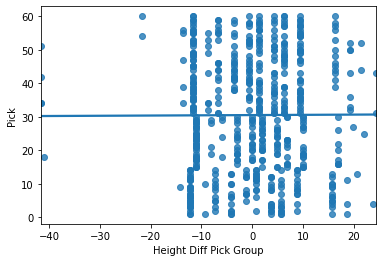

In [10]:
#POSITIONAL HEIGHT DIFF
hd = sns.regplot(data = data, x = 'Height Diff Pick Group', y = 'Pick', ci = None)
hd

In [12]:
!pip install statsmodels

#Use sm to get line equation
import statsmodels.api as sm

Y = data['Pick'].values.reshape(-1,1)
X = data['Height Diff Pick Group'].values.reshape(-1,1)

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print(model.summary())
# y = 30.5 - 0.007x; low correlation between just height and pick

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.009104
Date:                Tue, 08 Dec 2020   Prob (F-statistic):              0.924
Time:                        19:21:52   Log-Likelihood:                -2562.4
No. Observations:                 600   AIC:                             5129.
Df Residuals:                     598   BIC:                             5138.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.5000      0.708     43.068      0.0

### Test Correlation between Height AND Position to Pick
We saw that height diff by pick group doesn't have a very strong correlation with data, but we think this might be because height matters depending on position.

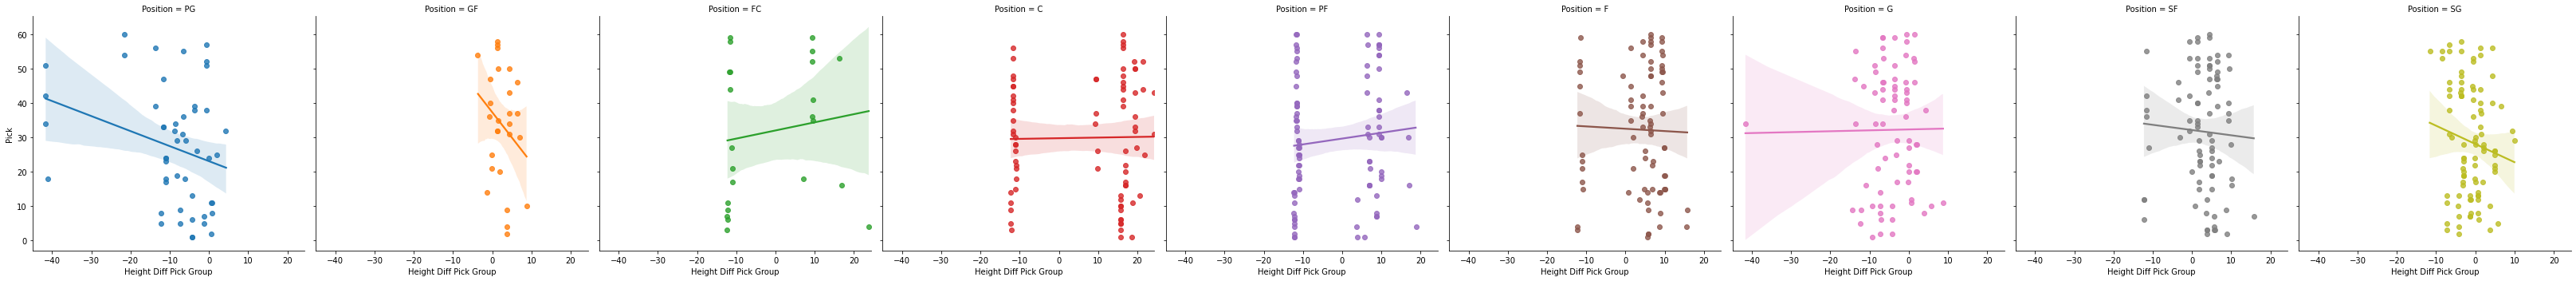

In [13]:
g = sns.lmplot(x="Height Diff Pick Group", y="Pick", hue="Position", col="Position",
               data=data, x_jitter=.1)

# Negative correlation is what we want; higher height diff (taller than average) leads to lower pick (earlier pick)
# Seems like height is a more useful measure for centers and point guard than for any others 

** Takeaway: we have to look at position to look at height feature. For centers and  guards, height differential has a more meaningful correlation with pick number!! 
But this isn't the case with for all positions: forwards seem to not have a correlation with height diff.** 

In [14]:
#COMPARING HEIGHTS TO AVG POSITIONAL HEIGHTS

#Creating a dictionary of average heights per position
pos_grp = data.groupby('Position').mean()['Draft Height']
dic = pos_grp.to_dict()

#Creating a list of all heights to make it easier to create df column
heights = []
for i in data['Position']:
    heights.append(dic[i])

#Creating the column of height diff by subtracting average height from players height
data['Height Diff'] = data['Draft Height'] - heights
data

,Name,Pick,Draft Year,Position,Draft Height,Draft Weight,Draft Age,College,Useless1,Useless2,...,TRB,AST,STL,BLK,PF,TOV,PTS,Pick Group,Height Diff Pick Group,Height Diff
0,John Wall,1,2010,PG,193,95,19,Kentucky,CAREER,NCAA DI,...,4.30,6.43,1.78,0.51,1.95,4.00,16.65,0,-4.257143,5.612245
1,Evan Turner,2,2010,GF,201,100,21,Ohio State,CAREER,NCAA DI,...,6.75,4.10,1.58,0.73,2.70,3.49,15.02,0,3.742857,1.888889
2,Derrick Favors,3,2010,FC,185,120,18,Georgia Tech,CAREER,NCAA DI,...,8.42,1.03,0.89,2.06,2.61,2.50,12.44,0,-12.257143,-10.260870
3,Wesley Johnson,4,2010,GF,201,98,22,Syracuse,CAREER,NCAA DI,...,6.99,1.61,1.14,1.16,2.27,2.15,13.90,0,3.742857,1.888889
4,DeMarcus Cousins,5,2010,C,185,122,19,Kentucky,CAREER,NCAA DI,...,9.87,1.00,0.97,1.76,3.21,2.08,15.13,0,-12.257143,-18.493506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Jaylen Hands,56,2019,G,190,86,20,UCLA,CAREER,NCAA DI,...,3.81,4.41,1.16,0.16,1.39,2.53,12.08,2,-6.636667,-2.135135
596,Jordan Bone,57,2019,SG,190,84,21,Tennessee,CAREER,NCAA DI,...,2.41,4.26,0.67,0.06,1.24,1.58,9.69,2,-6.636667,-5.440860
597,Miye Oni,58,2019,SF,196,93,22,Yale,CAREER,NCAA DI,...,6.20,3.30,0.85,1.02,2.82,2.55,15.03,2,-0.636667,-3.180723
598,Dewan Hernandez,59,2019,FC,185,107,22,Miami (FL),CAREER,NCAA DI,...,4.88,0.31,0.45,0.88,1.89,1.16,8.62,2,-11.636667,-10.260870


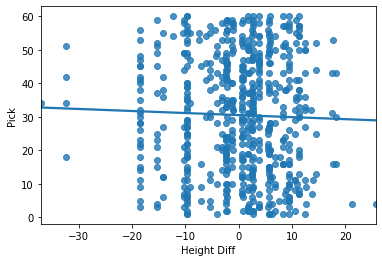

In [15]:
#POSITIONAL HEIGHT DIFF
hdpg = sns.regplot(data = data, x = 'Height Diff', y = 'Pick', ci = None)
hdpg

Looks like the correlation is slightly higher for Height Diff based on Positions. But this correlation only shows the individual effect of Height Diff on Pick, so we don't expect the slope of the trend line to be very steep. We'll include both Height Diffs in our model to see how it performs with other variables.

### Investigating Changing Trends over Time
We know that the draft changes moderately year to year, so investigating these changes can help us understand whether results can vary between years.

In [16]:
#average pick number per year per position
#line plot

time = data.groupby(['Draft Year', 'Position']).mean()
time.head()

Pick  Draft Height  Draft Weight  Draft Age  \
Draft Year Position                                                     
2010       C         35.400000    202.500000    118.700000  21.200000   
           F         40.750000    201.375000    103.875000  21.562500   
           FC        23.400000    189.200000    118.000000  19.800000   
           G         27.750000    194.750000     92.750000  21.125000   
           GF        19.428571    200.142857     97.285714  20.857143   

                             GP         GS        MIN       FGM        FGA  \
Draft Year Position                                                          
2010       C          73.800000  49.900000  20.910000  3.824000   6.759000   
           F         107.375000  86.250000  26.968750  4.756875   9.339375   
           FC         61.200000  45.400000  22.660000  3.944000   7.104000   
           G          86.750000  69.875000  29.962500  4.860000  10.991250   
           GF         74.142857  71.571429  32.757143  5.125714  11.122857   

                          FG%  ...       TRB       AST       STL       BLK  \
Draft Year Position            ...                                           
2010       C         0.568400  ...  6.586000  0.603000  0.483000  1.922000   
           F         0.518313  ...  7.047500  1.245625  0.783125  0.861250   
           FC        0.552600  ...  6.054000  1.268000  0.704000  1.610000   
           G         0.441000  ...  4.005000  3.057500  1.196250  0.262500   
           GF        0.461857  ...  6.404286  2.800000  1.344286  0.677143   

                           PF      TOV        PTS  Pick Group  \
Draft Year Position                                             
2010       C         2.294000  1.56500  10.109000    1.600000   
           F         2.278750  1.78125  12.652500    1.562500   
           FC        2.324000  1.88600  10.256000    1.000000   
           G         1.931250  2.24250  14.062500    1.250000   
           GF        2.305714  2.61000  15.401429    0.714286   

                     Height Diff Pick Group  Height Diff  
Draft Year Position                                       
2010       C                       5.739238    -0.993506  
           F                       4.773118     1.087500  
           FC                     -7.565024    -6.060870  
           G                      -1.664643     2.614865  
           GF                      3.237228     1.031746  

[5 rows x 28 columns]

In [17]:
time_data = time.reset_index()
time_data.head()

,Draft Year,Position,Pick,Draft Height,Draft Weight,Draft Age,GP,GS,MIN,FGM,...,TRB,AST,STL,BLK,PF,TOV,PTS,Pick Group,Height Diff Pick Group,Height Diff
0,2010,C,35.400000,202.500000,118.700000,21.200000,73.800000,49.900000,20.910000,3.824000,...,6.586000,0.603000,0.483000,1.922000,2.294000,1.56500,10.109000,1.600000,5.739238,-0.993506
1,2010,F,40.750000,201.375000,103.875000,21.562500,107.375000,86.250000,26.968750,4.756875,...,7.047500,1.245625,0.783125,0.861250,2.278750,1.78125,12.652500,1.562500,4.773118,1.087500
2,2010,FC,23.400000,189.200000,118.000000,19.800000,61.200000,45.400000,22.660000,3.944000,...,6.054000,1.268000,0.704000,1.610000,2.324000,1.88600,10.256000,1.000000,-7.565024,-6.060870
3,2010,G,27.750000,194.750000,92.750000,21.125000,86.750000,69.875000,29.962500,4.860000,...,4.005000,3.057500,1.196250,0.262500,1.931250,2.24250,14.062500,1.250000,-1.664643,2.614865
4,2010,GF,19.428571,200.142857,97.285714,20.857143,74.142857,71.571429,32.757143,5.125714,...,6.404286,2.800000,1.344286,0.677143,2.305714,2.61000,15.401429,0.714286,3.237228,1.031746


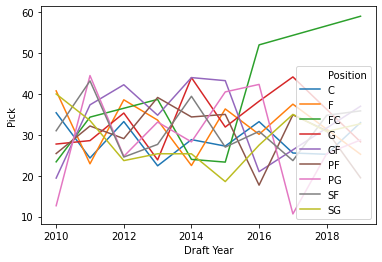

In [18]:
#Plot avg pick number for each position over time
sns.lineplot(data=time_data, x="Draft Year", y="Pick", hue="Position")

#Lots of variation for positional pick trends over the years; only real trend was for "FC" increasing towards present day

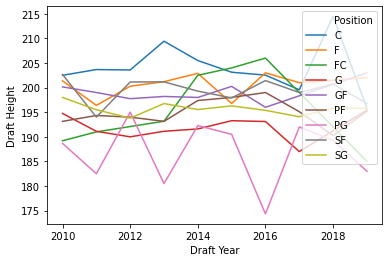

In [19]:
#Plot avg height for each position over time
sns.lineplot(data=time_data, x="Draft Year", y="Draft Height", hue="Position")

#This confirms our hypothesis that Draft Height and Position are very correlated, as trends stay similar over the years

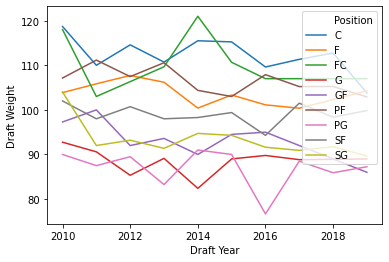

In [20]:
#Plot avg weight for each position over time
sns.lineplot(data=time_data, x="Draft Year", y="Draft Weight", hue="Position")

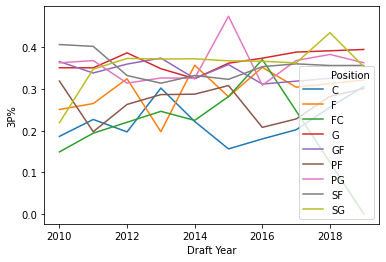

In [21]:
#Avg 3P% per position over time
sns.lineplot(data=time_data, x="Draft Year", y="3P%", hue="Position")

#Also lots of variation through different years

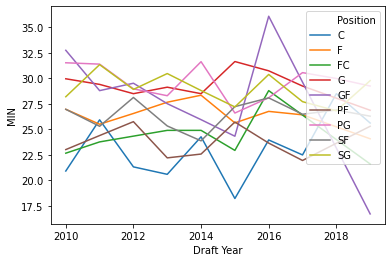

In [22]:
#Avg Min Played per position over time
sns.lineplot(data=time_data, x="Draft Year", y="MIN", hue="Position")

**TLDR, we can see heavy fluctuation of each feature through multiple years, so modeling results might change throughout different years.**

## Dimensionality Reduction - Sid

In [23]:
data.columns

Index(['Name', 'Pick', 'Draft Year', 'Position', 'Draft Height',
       'Draft Weight', 'Draft Age', 'College', 'Useless1', 'Useless2',
       'useless3', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OFF', 'DEF', 'TRB', 'AST', 'STL', 'BLK', 'PF',
       'TOV', 'PTS', 'Pick Group', 'Height Diff Pick Group', 'Height Diff'],
      dtype='object')

### t-SNE

In [24]:
from sklearn.manifold import TSNE

data_to_reduce = data.iloc[:,1:].drop(columns=['Pick', 'College', 'Pick Group', 'Draft Year', 'Useless1', 'Useless2', 'useless3'])
data_to_reduce = pd.get_dummies(data_to_reduce, columns=['Position'])
data_to_reduce.fillna(0, inplace=True)
data_to_reduce.head()
# data_to_reduce.isna().sum()

,Draft Height,Draft Weight,Draft Age,GP,GS,MIN,FGM,FGA,FG%,3PM,...,Height Diff,Position_C,Position_F,Position_FC,Position_G,Position_GF,Position_PF,Position_PG,Position_SF,Position_SG
0,193,95,19,37.0,37.0,34.8,5.46,11.84,0.461,1.00,...,5.612245,0,0,0,0,0,0,1,0,0
1,201,100,21,101.0,94.0,32.8,5.34,10.61,0.503,0.53,...,1.888889,0,0,0,0,1,0,0,0,0
2,185,120,18,36.0,35.0,27.5,4.97,8.14,0.611,0.00,...,-10.260870,0,0,1,0,0,0,0,0,0
3,201,98,22,93.0,90.0,31.6,4.97,10.94,0.454,1.40,...,1.888889,0,0,0,0,1,0,0,0,0
4,185,122,19,38.0,37.0,23.5,5.42,9.68,0.560,0.03,...,-18.493506,1,0,0,0,0,0,0,0,0


In [25]:
data_reduced=TSNE(n_components=2, perplexity=10, verbose=2, method='barnes_hut').fit_transform(data_to_reduce)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.001s...
[t-SNE] Computed neighbors for 600 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 5.815355
[t-SNE] Computed conditional probabilities in 0.012s
[t-SNE] Iteration 50: error = 74.0513153, gradient norm = 0.4884759 (50 iterations in 0.153s)
[t-SNE] Iteration 100: error = 68.8774109, gradient norm = 0.4953295 (50 iterations in 0.137s)
[t-SNE] Iteration 150: error = 67.1125259, gradient norm = 0.4994377 (50 iterations in 0.087s)
[t-SNE] Iteration 200: error = 67.7966385, gradient norm = 0.4811427 (50 iterations in 0.100s)
[t-SNE] Iteration 250: error = 67.9388733, gradient norm = 0.4885048 (50 iterations in 0.114s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.938873
[t-SNE] Iteration 300: error = 0.9073421, gradient norm = 0.0024893 (50 iterations in 0.087s)
[t-SNE] Iteration 350: error = 0.7347775, gradient norm = 0.0008552 (

In [26]:
d_tsne = {'x': data_reduced[:,0], 'y': data_reduced[:,1], 'pick': data['Pick'], 'name': data['Name'], 'pick group': data['Pick Group'], 'position': data['Position']}
df_tsne_csv = pd.DataFrame(data=d_tsne)
df_tsne_csv.head()

,x,y,pick,name,pick group,position
0,-56.041439,12.045420,1,John Wall,0,PG
1,40.773216,-17.403320,2,Evan Turner,0,GF
2,-10.131955,62.383240,3,Derrick Favors,0,FC
3,38.970360,-16.091948,4,Wesley Johnson,0,GF
4,-10.577070,64.487602,5,DeMarcus Cousins,0,C


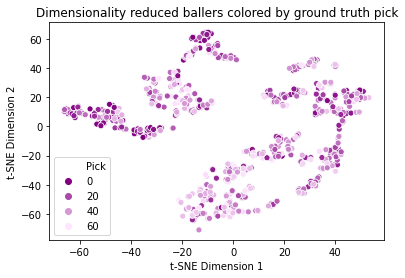

In [27]:
from matplotlib import pyplot as plt

x_axis= data_reduced[:,0]
y_axis=data_reduced[:,1]

# fig, ax = plt.subplots()

# scatter = ax.scatter(x_axis, y_axis, c=data['Pick'], s=5)
# legend = ax.legend(*scatter.legend_elements(), loc="best", title="Pick")
# ax.add_artist(legend)
plt.figure()
sns.scatterplot(x="x", y="y", hue="pick", palette=sns.light_palette("purple", as_cmap=True, reverse=True), data=d_tsne)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Dimensionality reduced ballers colored by ground truth pick")
plt.show()

In [28]:
#df_tsne_csv.to_csv('d3-scatterplot/tsne_reduced_ballers.tsv', sep='\t', index=False)

### PCA

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_to_reduce)
d_pca = {'x': pca_result[:,0], 'y': pca_result[:,1], 'pick': data['Pick'], 'name': data['Name'], 'pick group': data['Pick Group'], 'position': data['Position']}

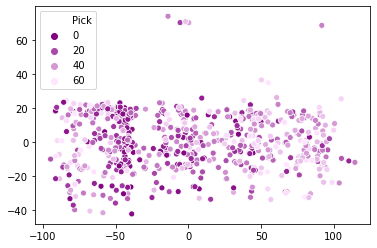

In [30]:
plt.figure()
sns.scatterplot(x="x", y="y", hue="pick", palette=sns.light_palette("purple", as_cmap=True, reverse=True), data=d_pca)

When displayed with the ground truth pick values, PCA gives us a nice continuous distribution across component 1 on the x axis, based on just player stats, positions, etc. Component 1, as expected, does extremely well at predicting ground truth pick values. Almost all the players we see on the very left side are international players, so technically our graph should end at the large dark column on the left:

```
56	Chu Maduabum	2	Guard
59	Adam Hanga	2	Forward
50	Izzet Turkyilmaz	2	Center
52	Ognen Kuzmic	2	Guard
54	Tornike Shengelia	2	Forward
57	Ilkan Karaman	2	Guard
16	Lucas Nogueira	1	Forward
19	Sergey Karasev	1	Guard
30	Nemanja Nedovic	1	Forward
59	Bojan Dubljevic	2	Forward
60	Janis Timma	2	Forward
20	Bruno Caboclo	1	Forward
31	Damien Inglis	2	Guard
52	Vasilje Micic	2	Center
54	Nemanja Dangubic	2	Forward
57	Louis Labeyrie	2	Guard
7	Emmanuel Mudiay	0	Guard
26	Nikola Milutinov	1	Guard
29	Chris McCullough	1	Guard
47	Arturas Gudaitis	2	Center
...
```
The players at the very left ^

PCA component 2 seems to correlate highly with height, weight, and position, placing people like Satnam Singh, Evan Fourier, and Jusuf Nurkić at the opposite end of people like Kyrie Irving or Dennis Schröder, who comparatively are much shorter. PCA component 1 on the x-axis, as mentioned, correlates highly with performance (and thus our ground truth pick). Someone like Dexter Pittman, who's quite tall and a relatively no-name in the community, is expectedly on the top right end of our PCA visualization of the first two components. Some of the shortest people like Isaiah Thomas or Kay Felder are consequently near the bottom right.

In [31]:
#df_pca_csv = pd.DataFrame(data=d_pca)
#df_pca_csv.to_csv('d3-scatterplot/pca_reduced_ballers.tsv', sep='\t', index=False)

#### PCA on Test Data (2020 Draft)

In [32]:
xls = pd.ExcelFile('ballas.xlsx')
df_test = pd.read_excel(xls, 'realtesthoopers')
data_to_reduce_test = df_test.drop(columns=['Name', 'Pick', 'College', 'Draft Year', 'Useless1', 'Useless2', 'useless3'])
data_to_reduce_test = pd.get_dummies(data_to_reduce_test, columns=['Position'])
data_to_reduce_test.fillna(0, inplace=True)
data_to_reduce_test.head()

,Draft Height (cm),Draft Weight (kg),Draft Age,GP,GS,MIN,FGM,FGA,FG%,3PMS,...,TOV,PTS,Position_C,Position_F,Position_FC,Position_G,Position_PF,Position_PG,Position_SF,Position_SG
0,196,102,19,32,31,33.0,6.34,15.78,0.402,2.25,...,2.72,19.06,0,0,0,0,0,0,1,0
1,216,109,19,3,3,23.0,6.67,8.67,0.769,0.00,...,1.00,19.67,1,0,0,0,0,0,0,0
2,201,82,19,13,13,31.3,6.31,16.23,0.389,1.85,...,2.54,17.15,0,0,0,1,0,0,0,0
3,203,102,19,29,0,22.5,3.28,7.14,0.459,0.55,...,1.72,9.24,0,0,0,1,0,0,0,0
4,196,102,19,28,28,31.5,4.46,8.75,0.510,0.71,...,1.96,12.82,0,0,0,0,0,0,0,1


In [33]:
pca_test = PCA(n_components=2)
pca_result_test = pca_test.fit_transform(data_to_reduce_test)
d_pca_test = {'x': pca_result_test[:,0], 'y': pca_result_test[:,1], 'pick': df_test['Pick'], 'name': df_test['Name'], 'position': df_test['Position']}

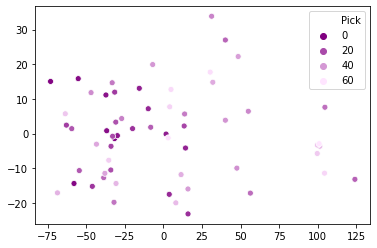

In [34]:
plt.figure()
sns.scatterplot(x="x", y="y", hue="pick", palette=sns.light_palette("purple", as_cmap=True, reverse=True), data=d_pca_test)

This is PCA for the 2020 draft test data, plotted with the ground truth values of pick. PC1 is not the best model in this case, and we'll see why later on. The 2020 draft is an outlier compared to all other years.

## Clustering — Jessica

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clustering_data = data.copy()
clustering_data = data.drop(columns= ['College', 'Pick Group', 'Draft Year', 'Useless1', 'Useless2', 'useless3'])
clustering_data = clustering_data.set_index('Name')
clustering_data = pd.get_dummies(clustering_data)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

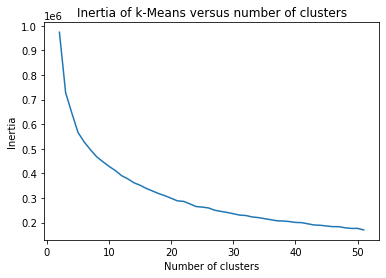

In [36]:
# !pip install seaborn
# !pip install numpy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

scores = [KMeans(n_clusters=i+2).fit(clustering_data.fillna(0)).inertia_ for i in range(50)]
sns.lineplot(np.arange(2, 52), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [37]:
# From the plot I made looking at the inertias for different cluster numbers, I used the elbow method to pinpoint that k=10 was a good number of clusters.
kmeans = KMeans(n_clusters=10, random_state=42).fit(clustering_data.fillna(0))
# curr_score = silhouette_score(clustering_data, kmeans.labels_)
clustering_data['Cluster'] = kmeans.labels_
clustering_data[clustering_data['Cluster'] == 5]
#Cluster 1 all second rounders
#

,Pick,Draft Height,Draft Weight,Draft Age,GP,GS,MIN,FGM,FGA,FG%,...,Position_C,Position_F,Position_FC,Position_G,Position_GF,Position_PF,Position_PG,Position_SF,Position_SG,Cluster
Name,,,,,,,,,,,,,,,,,,,,,
Evan Turner,2,201,100,21,101.0,94.0,32.8,5.34,10.61,0.503,...,0,0,0,0,1,0,0,0,0,5
Wesley Johnson,4,201,98,22,93.0,90.0,31.6,4.97,10.94,0.454,...,0,0,0,0,1,0,0,0,0,5
Ekpe Udoh,6,185,111,23,103.0,67.0,27.3,3.33,7.05,0.472,...,0,0,0,0,0,1,0,0,0,5
Cole Aldrich,11,185,115,21,111.0,71.0,21.0,3.52,6.14,0.574,...,1,0,0,0,0,0,0,0,0,5
Patrick Patterson,14,206,104,21,97.0,97.0,33.9,6.36,10.86,0.586,...,0,1,0,0,0,0,0,0,0,5
Larry Sanders,15,185,107,21,101.0,82.0,23.7,4.11,7.90,0.520,...,0,0,0,0,0,1,0,0,0,5
James Anderson,20,198,95,21,101.0,99.0,32.8,5.77,12.55,0.460,...,0,0,0,0,1,0,0,0,0,5
Craig Brackins,21,185,104,22,96.0,95.0,31.8,5.96,13.39,0.445,...,0,1,0,0,0,0,0,0,0,5
Dominique Jones,25,193,98,21,95.0,94.0,36.5,6.23,14.08,0.442,...,0,0,0,1,0,0,0,0,0,5


In [38]:
#Each cluster's average statistics
clustering_data.groupby("Cluster").agg(np.mean)

,Pick,Draft Height,Draft Weight,Draft Age,GP,GS,MIN,FGM,FGA,FG%,...,Height Diff,Position_C,Position_F,Position_FC,Position_G,Position_GF,Position_PF,Position_PG,Position_SF,Position_SG
Cluster,,,,,,,,,,,,,,,,,,,,,
0,17.608696,201.072464,99.507246,20.188406,69.202899,57.565217,29.015942,4.743768,9.834203,0.487899,...,4.108721,0.144928,0.188406,0.014493,0.130435,0.043478,0.101449,0.086957,0.130435,0.159420
1,39.659341,195.978022,97.934066,22.164835,135.076923,116.153846,28.943956,4.553626,9.649121,0.476714,...,-0.492768,0.054945,0.263736,0.032967,0.186813,0.043956,0.087912,0.076923,0.120879,0.131868
2,41.690909,206.181818,102.272727,20.163636,17.444444,9.253704,20.101111,3.485185,6.497648,0.525778,...,7.906933,0.290909,0.072727,0.018182,0.036364,0.072727,0.254545,0.054545,0.163636,0.036364
3,43.529412,198.098039,97.098039,21.176471,89.529412,68.215686,27.684314,4.240588,9.108235,0.470392,...,1.660013,0.039216,0.117647,0.039216,0.156863,0.117647,0.078431,0.058824,0.196078,0.196078
4,10.621622,191.459459,97.527027,19.000000,33.567568,30.540541,30.468784,5.230541,10.862432,0.489378,...,-3.282377,0.081081,0.054054,0.040541,0.081081,0.013514,0.135135,0.229730,0.148649,0.216216
5,21.928571,194.589286,96.964286,21.232143,103.839286,88.017857,29.758929,4.789464,10.173929,0.477429,...,-0.334695,0.053571,0.071429,0.035714,0.285714,0.071429,0.125000,0.089286,0.053571,0.214286
6,44.759259,197.277778,100.462963,22.351852,130.055556,75.611111,23.838889,3.691296,7.696481,0.488593,...,-0.292185,0.129630,0.203704,0.074074,0.148148,0.018519,0.129630,0.000000,0.166667,0.129630
7,21.350000,205.616667,104.516667,19.483333,42.183333,27.600000,25.011667,4.262167,8.671333,0.498083,...,7.652726,0.216667,0.100000,0.033333,0.033333,0.033333,0.200000,0.016667,0.150000,0.216667
8,38.367347,187.306122,103.673469,20.040816,29.734694,11.795918,19.889796,3.234490,6.537347,0.503224,...,-10.684348,0.244898,0.081633,0.081633,0.020408,0.000000,0.244898,0.040816,0.204082,0.081633


**Cluster Interpretations** : Clusters aren't too differentiated by year which is good (means all clusters are filled with players from all years in our table)

Cluster 1 = top picks -> pick avg = 9.46

Cluster 6 = mainly point guards, weigh the least -> 58%

Cluster 7 = mainly shooting forwards -> 57%

Cluster 9 = only point forwards and shooting forwards (more pf though)



## Modeling

#### Splitting Train & Test Groups

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [62]:
#For using years that are not 2020 for test set
df_train = data[data['Draft Year'] != 2019]
df_test = data[data['Draft Year'] == 2019]


#For 2020
#df_train = data
#xls = pd.ExcelFile('ballas.xlsx')
#df_test = pd.read_excel(xls, 'realtesthoopers')

In [63]:
#Just looking at which features we are keeping/deleting
will_remove = ['Draft Year', 'Name', 'Draft Height', 'Pick', 'Useless1', 
'Useless2', 'useless3', '3P%', 'GS', 'FT%', 'TRB', 'FG%', 'College', 'Pick Group', '3PA',
'FTA', ]

will_keep = [i for i in list(data.columns) if  i not in will_remove]
will_keep

['Position',
 'Draft Weight',
 'Draft Age',
 'GP',
 'MIN',
 'FGM',
 'FGA',
 '3PM',
 'FTM',
 'OFF',
 'DEF',
 'AST',
 'STL',
 'BLK',
 'PF',
 'TOV',
 'PTS',
 'Height Diff Pick Group',
 'Height Diff']

In [64]:
#seperate the X (features) and Y (prediction)
x_feats = list(df_train.columns)

In [65]:
#Dropping all categorical variables and some non-important features
#this is just a dummy method, you don't have to drop so many/any columns. 
#Infact you may want to use some of these columns to engineer other features

for f in will_remove:
  x_feats.remove(f)

x_train = df_train[x_feats]
y_train = df_train['Pick Group']

x_train = pd.get_dummies(x_train, columns=['Position'])

**THIS FOLLOWING CELL IS FOR 2020 ONLY because test set needs to add features that we added to training dataframe.**


In [51]:

#for f in ['Player', 'Age', 'Height', 'Pick', 'Pick Group']:
  #x_feats.remove(f)
df_test = df_test.rename(columns = {'Draft Height (cm)': 'Draft Height', 'Draft Weight (kg)':'Draft Weight', '3PMS': '3PM'})
group_lst = []

for i in range(len(df_test['Name'])):
    if df_test.iloc[i]['Pick'] <= 14:
        group_lst.append(0)
    if df_test.iloc[i]['Pick'] > 14 and data.iloc[i]['Pick'] <= 30:
        group_lst.append(1)
    if df_test.iloc[i]['Pick'] > 30 and data.iloc[i]['Pick'] <= 60:
        group_lst.append(2) 

df_test['Pick Group'] = group_lst

#Creating a dictionary of average heights per position
pos_grp = df_test.groupby('Position').mean()['Draft Height']
dic = pos_grp.to_dict()

#Drop nans
df_test = df_test.fillna(data.mean())

#Creating a list of all heights to make it easier to create df column
heights = []
for i in df_test['Position']:
    heights.append(dic[i])

#Creating the column of height diff by subtracting average height from players height
df_test['Height Diff'] = df_test['Draft Height'] - heights


#Creating a dictionary of average heights per Pick Group
pos_grp = df_test.groupby('Pick Group').mean()['Draft Height']
dic = pos_grp.to_dict()

#Creating a list of all heights to make it easier to create df column
heights = []
for i in df_test['Pick Group']:
    heights.append(dic[i])

#Creating the column of height diff by subtracting average height from players height
df_test['Height Diff Pick Group'] = df_test['Draft Height'] - heights

x_test = df_test[x_feats]
y_test = df_test['Pick Group']
#we switch Pick for Pick Group if we want to predict group vs number

x_test = pd.get_dummies(x_test, columns=['Position'])

**FOR DRAFT CLASSES BESIDES 2020 TEST SETS**

In [66]:
#FOR DRAFT CLASSES BESIDES 2020 for test sets
x_test = df_test[x_feats]
x_test = pd.get_dummies(x_test, columns=['Position'])

y_test = df_test['Pick Group']

In [67]:
#Certain years don't have certain positions, so when positions 
#column is dummied it doesn't create certain columns
lst_not = []
for i in x_train.columns:
    if i not in x_test.columns:
        x_test[i] = 0

#There are still some NaN values so filling it with the mean
x_train = x_train.fillna(x_train.mean())
y_train = y_train.fillna(y_train.mean())

x_test = x_test.fillna(x_test.mean())
y_test = y_test.fillna(y_test.mean())

#### Model Testing:

In [54]:
#Standardize model with max min scaling
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

#scaler.fit(x_train)
#x_train = scaler.transform(x_train)

#scaler.fit(x_test)
#x_test = scaler.transform(x_test)

In [68]:
#Individual Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)
print(accuracy_score(clf.predict(x_train), y_train))
print(accuracy_score(clf.predict(x_test), y_test))

1.0
0.55


In [69]:
#Bagging
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=150,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)
bag_clf.fit(x_train, y_train)
print(accuracy_score(bag_clf.predict(x_train), y_train))
print(accuracy_score(bag_clf.predict(x_test), y_test))

1.0
0.7


In [70]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
print(accuracy_score(rf.predict(x_train), y_train))
print(accuracy_score(rf.predict(x_test), y_test))

1.0
0.6


In [71]:
#Linear Support Vectors
from sklearn.svm import SVC, LinearSVC
lsv = LinearSVC(max_iter=200000)
lsv.fit(x_train, y_train)
print(accuracy_score(lsv.predict(x_train), y_train))
print(accuracy_score(lsv.predict(x_test), y_test))

0.8222222222222222
0.8166666666666667


/Users/joyceli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [85]:
#Neural Network with Scikit-learn
from sklearn.neural_network import MLPClassifier  #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

clf = MLPClassifier(hidden_layer_sizes=(500,10,100), activation = 'tanh', max_iter=500,
                     solver='lbfgs', verbose= True,  random_state=42)  #sgd = Stochastic Gradient descent. Also, check 'lbfgs’, ‘adam’}
                                                                #Default activation is 'relu'
                                                                #Default n_iter_no_change=10

clf.fit(x_train,y_train)

print('Accuracy on training---')
y_pred_train=clf.predict(x_train)
print(accuracy_score(y_train,y_pred_train))

print('Accuracy on test---')
y_pred_test=clf.predict(x_test)
print(accuracy_score(y_test,y_pred_test))


Accuracy on training---
0.9981481481481481
Accuracy on test---
0.5
/opt/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [73]:
#Boosting (sklearn AdaBoost)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators= 500, learning_rate = 0.5, random_state=42)
boost.fit(x_train, y_train)

boost.predict(x_test)

boost.score(x_train, y_train)

boost.score(x_test, y_test)

0.6666666666666666

#### Final Model: Simple Combination Ensemble of High Performing Individual Models

Add and delete models depending on individual performance, then voting classifier will pick majority vote from provided classifiers.

In [74]:
#Simple Combination of Individual Classifiers & Ensembles

from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

# create the sub models
estimators = []

model1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators= 500, learning_rate = 0.5, random_state=42)
estimators.append(('boost', model1))

model2 = GradientBoostingClassifier(n_estimators=1000, max_depth=10, learning_rate=1, random_state=42)
estimators.append(('gradient', model2))

model3 = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=150, bootstrap=True, n_jobs=-1, random_state=42)
estimators.append(('bagging dt', model3))

model4 = lsv = LinearSVC(max_iter=200000)
estimators.append(('linear vector', model4))

model5= GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, random_state=42)
estimators.append(('gradient2', model5))

#model6 = DecisionTreeClassifier(max_depth=10)
#estimators.append(('decision tree', model6))

#model7 = MLPClassifier(hidden_layer_sizes=(500,10,100), activation = 'tanh', max_iter=750,solver='lbfgs', verbose= True,  random_state=42)
#estimators.append(('nn', model7))

#model8 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators= 100, learning_rate = 1, random_state=42)
#estimators.append(('boost2', model8))


# create the ensemble model
ensemble = VotingClassifier(estimators, voting='hard')

ensemble.fit(x_train, y_train) 

y_pred_train = ensemble.predict(x_train)

y_pred = ensemble.predict(x_test)
  
# using accuracy_score metric to predict accuracy 
train_score = accuracy_score(y_train, np.array(y_pred_train))
score = accuracy_score(y_test, np.array(y_pred)) 
print ('Training Accuracy:', train_score)
print ('Test Accuracy:', score)




/Users/joyceli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training Accuracy: 1.0
Test Accuracy: 0.85


In [61]:
#y_test, y_pred

### Investigating Feature Importance in our Final Model

In [71]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

# ... load data
perm = PermutationImportance(ensemble).fit(x_test, y_test)
eli5.show_weights(perm)

     |████████████████████████████████| 105 kB 5.4 MB/s eta 0:00:01


/Users/joyceli/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/joyceli/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.3533 ± 0.0904,x16
0.0500 ± 0.0558,x1
0.0300 ± 0.0573,x17
0.0200 ± 0.0389,x15
0.0200 ± 0.0133,x4
0.0100 ± 0.0163,x23
0.0067 ± 0.0163,x12
0.0067 ± 0.0340,x25
0.0033 ± 0.0133,x21
0.0033 ± 0.0490,x11


In [72]:
feature_dic = {}
for i in range(len(x_train.columns)):
    feature_dic[i] = x_train.columns[i]

feature_dic

{0: 'Draft Weight',
 1: 'Draft Age',
 2: 'GP',
 3: 'MIN',
 4: 'FGM',
 5: 'FGA',
 6: '3PM',
 7: 'FTM',
 8: 'OFF',
 9: 'DEF',
 10: 'AST',
 11: 'STL',
 12: 'BLK',
 13: 'PF',
 14: 'TOV',
 15: 'PTS',
 16: 'Height Diff Pick Group',
 17: 'Height Diff',
 18: 'Position_C',
 19: 'Position_F',
 20: 'Position_FC',
 21: 'Position_G',
 22: 'Position_GF',
 23: 'Position_PF',
 24: 'Position_PG',
 25: 'Position_SF',
 26: 'Position_SG'}

### Conclusions

When running our final model on the 2018 and 2019 drafts, we attained an accuracy of over 72%, which means that
our model correctly predicts whether players were drafted in the lottery round, first round, or second round
correctly 72% of the time. To make sure that the model wasn't just good at predicting later drafts, we tested it on the 
2010 and 2011 drafts as well (training the data on all years besides 2010 and 2011 respectively), 
getting accuracy scores over 70% for both. This proved to us that our model predicts general NBA draft trends
pretty well based on player performance pre-NBA.

One caveat was that we got a 42% accuracy for predicting the 2020 NBA Draft, which is a much lower score than we wanted. 
However, we hypothesize that this is because the 2020 Draft is actually considered to be a "weak" draft, 
one that's filled with lower quality players. This is further supported when looking at the actual predictions of our
model in 2020, as it predicts that a lot of players that were actually picked in the 1st round 
were predicted to be picked in 2nd round due to their poor pre-NBA performances.

However, because our model does well on most other years, and since there's a difference in accuracy of 
over 30% for 2020, we believe that our results for the 2020 draft were an outlier. 






